In [196]:
#IMPORTANT: Execute the code step by step because it takes files from other Notebooks and creates Excel files that are stored in the same folder as this Notebook

import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup

import matplotlib.pyplot as plt
import seaborn as sns

# Import libraries for data manipulation, numerical calculations, web scraping, and visualization
# - pandas: for data manipulation and analysis, especially useful for handling structured data in DataFrames.
# - numpy: for numerical operations, providing support for arrays and matrices, and high-level mathematical functions.
# - requests: for making HTTP requests to fetch data from the web.
# - BeautifulSoup: for parsing HTML and XML documents, making it easier to scrape information from web pages.
# - matplotlib.pyplot: for creating static, interactive, and animated visualizations. It's a comprehensive library for creating plots.
# - seaborn: for making statistical graphics, built on top of Matplotlib, making it easier to create complex visualizations with less code.


#Prior to the final development of the inflation graph, data was taken from the internet with another Notebook and cleaned and then imported into this Notebook.

In [197]:
#Import the necessary files and join them together

file_csv_immo = 'immo_data.csv'
regional_data = 'INGRESOS_REGIONES.xlsx'

df_immo = pd.read_csv(file_csv_immo)
df_income_region = pd.read_excel(regional_data)

df = df_immo.merge(df_income_region, left_on='regio1', right_on='regions', how='left')

In [199]:
#Remove columns not relevant to the analysis
df = df.drop(columns=['serviceCharge', 'heatingType', 'telekomTvOffer', 'telekomHybridUploadSpeed', 'newlyConst', 'telekomUploadSpeed', 'noParkSpaces', 'firingTypes', 'yearConstructedRange', 'houseNumber', 'interiorQual', 'petsAllowed', 'street', 'streetPlain', 'thermalChar', 'noRoomsRange', 'livingSpaceRange', 'description', 'facilities', 'heatingCosts', 'numberOfFloors', 'energyEfficiencyClass', 'lastRefurbish', 'electricityBasePrice', 'electricityKwhPrice', 'geo_krs', 'geo_bln'])

In [201]:
#Delete duplicate rows
duplicates = df.duplicated()

print(df[duplicates])

Empty DataFrame
Columns: [regio1, balcony, picturecount, pricetrend, totalRent, yearConstructed, scoutId, hasKitchen, cellar, baseRent, livingSpace, condition, lift, baseRentRange, typeOfFlat, geo_plz, noRooms, floor, garden, regio2, regio3, date, regions, BS_Insgesamt, BS_Männer, BS_Frauen, BF_Insgesamt, BF_Männer, BF_Frauen, GS_Insgesamt, GS_Männer, GS_Frauen]
Index: []

[0 rows x 32 columns]


In [202]:
#Remove duplicate column after merging files
df.drop('regions', axis=1, inplace=True)

In [203]:
#Keeping publications of dwellings with a surface area of less than 500 square meters
df = df[df['livingSpace'] <= 500]

In [204]:
#Maintain publications of dwellings with a surface area greater than 20 square meters
df = df[df['livingSpace'] >= 20]

In [205]:
#Convert years to whole numbers
df['yearConstructed'] = df['yearConstructed'].apply(lambda x: f"{x:.0f}" if x.is_integer() else x)

In [206]:
#Packaging of housing status information
condition_mapping = {'well_kept': 'pre-owned', 'refurbished': 'mint_condition', 'fully_renovated':'mint_condition', 'first_time_use':'mint_condition', 'mint_condition':'mint_condition', 'modernized':'mint_condition', 'first_time_use_after_refurbishment':'mint_condition', 'negotiable':'pre-owned', 'need_of_renovation':'need_of_renovation', 'ripe_for_demolition':'need_of_renovation'}
df['condition'] = df['condition'].map(condition_mapping)

In [207]:
# Define a function to categorize noRooms values
def bucket_rooms(x):
    if x < 2:
        return '1 Room/Studio'
    elif x < 3:
        return '2 Rooms'
    elif x < 4:
        return '3 Rooms'
    elif x < 5:
        return '4 Rooms'
    elif x <= 10:
        return '5-10 Rooms'
    elif x <= 20:
        return '11-20 Rooms'
    elif x <= 50:
        return '21-50 Rooms'
    else:
        return '51+ Rooms'

df['Room Category'] = df['noRooms'].apply(bucket_rooms)

In [208]:
#Eliminate zero values for rent and area of housing
df = df[df['baseRent'] != 0]
df = df[df['livingSpace'] != 0]

In [209]:
#Create a ratio between the rental price and the surface area
df['price_m2'] = df['baseRent'] / df['livingSpace']

In [210]:
#Create a ratio between price per square meter and revenue
df['price_m2_BS_Insgesamt'] = df['price_m2'] / df['BS_Insgesamt']

In [211]:
#Create bins to be able to group publications according to surface area
bins = range(0, int(df['livingSpace'].max()) + 20, 20)

df['rango_m2'] = pd.cut(df['livingSpace'], bins=bins)

count_ranges = df['rango_m2'].value_counts().sort_index()

print(count_ranges)

rango_m2
(0, 20]         310
(20, 40]      12613
(40, 60]      39349
(60, 80]      45033
(80, 100]     23106
(100, 120]    10965
(120, 140]     5376
(140, 160]     2475
(160, 180]     1146
(180, 200]      581
(200, 220]      321
(220, 240]      181
(240, 260]      108
(260, 280]       60
(280, 300]       43
(300, 320]       25
(320, 340]       14
(340, 360]        7
(360, 380]        8
(380, 400]        3
(400, 420]        5
(420, 440]        4
(440, 460]        6
(460, 480]        3
Name: count, dtype: int64


In [212]:
#Remove '_' from region names
df['regio1'] = df['regio1'].str.replace('_', ' ')

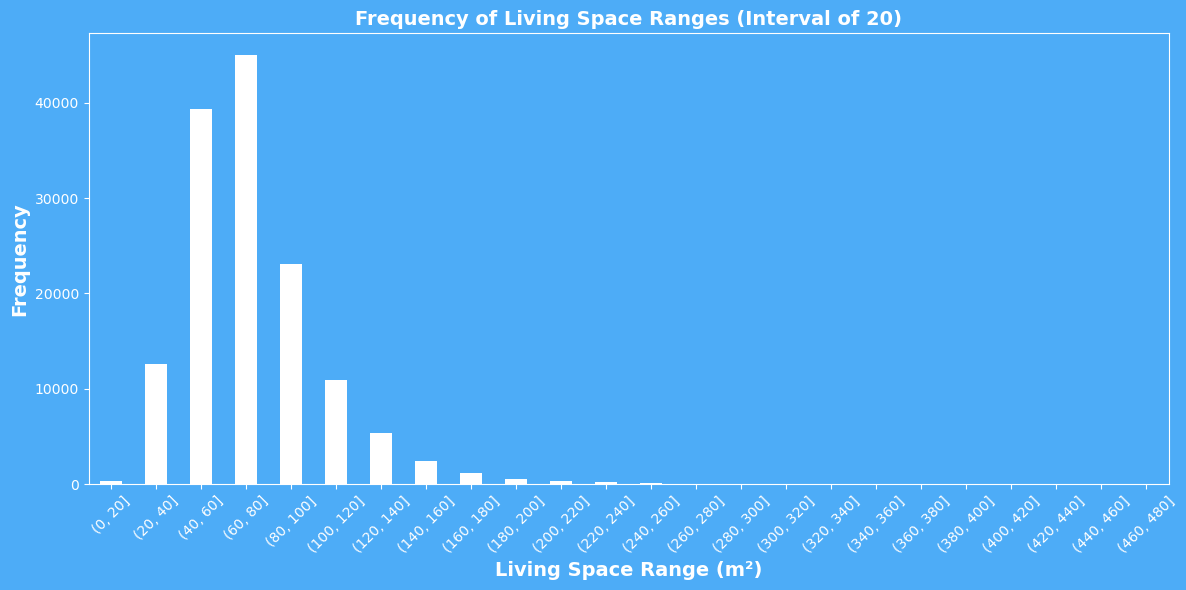

In [213]:
# Create the bar plot
fig, ax = plt.subplots(figsize=(12, 6))

# Background color settings
fig.patch.set_facecolor('#4dacf7')  # Background color outside plot area
ax.set_facecolor('#4dacf7')  # Background color inside plot area

# Bar settings
count_ranges.plot(kind='bar', ax=ax, color='white')

# Add labels and title
ax.set_xlabel('Living Space Range (m²)', color='white', fontsize=14, fontweight='bold')
ax.set_ylabel('Frequency', color='white', fontsize=14, fontweight='bold')
ax.set_title('Frequency of Living Space Ranges (Interval of 20)', color='white', fontsize=14, fontweight='bold')

# Rotate x-ticks for better readability
plt.xticks(rotation=45, color='white')

# Border colors
ax.spines['top'].set_color('white')
ax.spines['right'].set_color('white')
ax.spines['left'].set_color('white')
ax.spines['bottom'].set_color('white')

# Set tick labels color
ax.tick_params(axis='both', colors='white')

plt.tight_layout()

# Show the plot
plt.show()

In [214]:
#Identify ranges of outliers according to housing area
values = df['livingSpace'].dropna()

# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = values.quantile(0.25)
Q3 = values.quantile(0.75)

# Calculate the IQR
IQR = Q3 - Q1

# Determine the outlier limits
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
print(lower_bound)
print(upper_bound)

# Identify the outliers
outliers = values[(values < lower_bound) | (values > upper_bound)]

print("Outliers in 'square_meters':")
print(outliers)

6.121249999999989
135.35125
Outliers in 'square_meters':
20        160.00
22        140.00
115       136.00
135       170.00
182       148.00
           ...  
268542    161.00
268548    148.84
268594    140.00
268644    171.81
268714    155.00
Name: livingSpace, Length: 6094, dtype: float64


In [215]:
#Eliminate outliers according to housing surface
df = df[df['livingSpace'] >= lower_bound]
df = df[df['livingSpace'] <= upper_bound]

In [216]:
#Identify ranges of outliers according to price per square meter of housing
values_m2 = df['price_m2'].dropna()

# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1_m2 = values_m2.quantile(0.25)
Q3_m2 = values_m2.quantile(0.75)

# Calculate the IQR
IQR_m2 = Q3_m2 - Q1_m2

# Determine the outlier limits
lower_bound_m2 = Q1_m2 - 1.5 * IQR_m2
upper_bound_m2 = Q3_m2 + 1.5 * IQR_m2

print(lower_bound_m2)
print(upper_bound_m2)

# Identify the outliers
outliers_m2 = values_m2[(values_m2 < lower_bound_m2) | (values_m2 > upper_bound_m2)]

print("Outliers in 'price_m2':")
print(outliers_m2)

-1.010533245556286
16.606319947333773
Outliers in 'price_m2':
21        41.034483
23        22.839506
28        39.344262
34        26.714286
46        22.812500
            ...    
268586    19.247312
268623    22.857143
268669    16.666667
268752    41.612903
268818    17.070563
Name: price_m2, Length: 6889, dtype: float64


In [217]:
#Eliminate outliers according to price per square meter of housing
df = df[df['price_m2'] > 4]
df = df[df['price_m2'] <= upper_bound_m2]

In [218]:
#Create bins to be able to price per square meter of housing
bins_m2 = range(0, int(df['price_m2'].max()) + 4, 4)

df['price_m2'] = pd.cut(df['price_m2'], bins=bins_m2)

count_ranges_m2 = df['price_m2'].value_counts().sort_index()

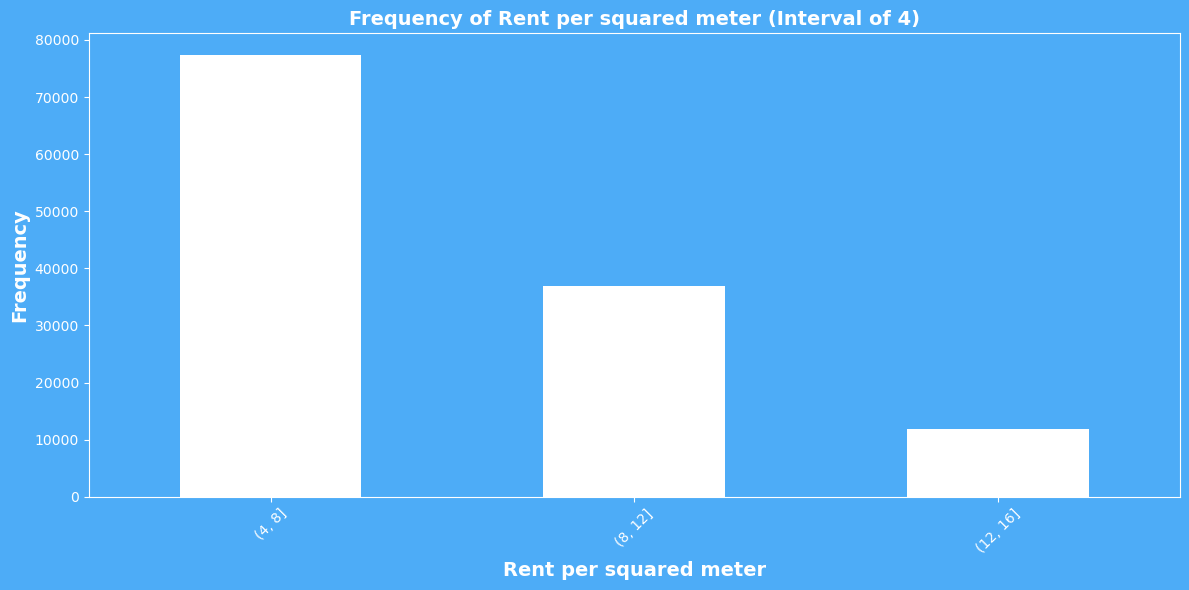

In [219]:
# Filter the data to include only values greater than 4
count_ranges_m2_filtered = count_ranges_m2[count_ranges_m2 > 4]

# Create the bar plot
fig, ax = plt.subplots(figsize=(12, 6))

# Background color settings
fig.patch.set_facecolor('#4dacf7')  # Background color outside plot area
ax.set_facecolor('#4dacf7')  # Background color inside plot area

# Bar settings
count_ranges_m2_filtered.plot(kind='bar', ax=ax, color='white')  # Use filtered data

# Add labels and title
ax.set_xlabel('Rent per squared meter', color='white', fontsize=14, fontweight='bold')
ax.set_ylabel('Frequency', color='white', fontsize=14, fontweight='bold')
ax.set_title('Frequency of Rent per squared meter (Interval of 4)', color='white', fontsize=14, fontweight='bold')

# Rotate x-ticks for better readability
plt.xticks(rotation=45, color='white')

# Border colors
ax.spines['top'].set_color('white')
ax.spines['right'].set_color('white')
ax.spines['left'].set_color('white')
ax.spines['bottom'].set_color('white')

# Set tick labels color
ax.tick_params(axis='both', colors='white')

plt.tight_layout()

# Show the plot
plt.show()

In [220]:
#Calculate statistical variables related to surface area according to each region
df.groupby(['regio1'])['livingSpace'].agg(['mean','max','min','median'])

,mean,max,min,median
regio1,,,,
Baden Württemberg,80.578038,135.32,20.00,80.665
Bayern,77.092608,135.00,20.00,76.650
Berlin,72.706647,135.00,20.00,70.000
Brandenburg,66.610857,135.00,20.00,62.150
Bremen,69.656604,135.00,21.45,66.875
Hamburg,76.617070,135.00,20.52,74.270
Hessen,78.978621,135.00,20.00,78.640
Mecklenburg Vorpommern,61.879935,134.89,20.00,60.000
Niedersachsen,73.018716,135.00,20.00,71.500


In [221]:
#Calculate statistical variables related to the rental price according to each region
df.groupby(['regio1'])['baseRent'].agg(['mean','max','min','median'])

,mean,max,min,median
regio1,,,,
Baden Württemberg,831.687774,2125.00,150.00,799.500
Bayern,779.927402,2104.00,120.20,750.000
Berlin,842.013200,2128.00,182.78,750.000
Brandenburg,481.032941,1790.00,129.00,387.240
Bremen,575.980988,1890.00,170.00,490.070
Hamburg,944.228201,2200.00,161.08,890.000
Hessen,814.105655,2200.00,100.00,750.000
Mecklenburg Vorpommern,414.403980,1595.00,103.00,347.440
Niedersachsen,567.649576,1800.00,108.50,513.175


In [222]:
#Calculate statistical variables related to the ratio between price per square meter and average salary according to each region
df.groupby(['regio1'])['price_m2_BS_Insgesamt'].agg(['mean','max','min','median'])

,mean,max,min,median
regio1,,,,
Baden Württemberg,0.002211,0.003515,0.000863,0.002141
Bayern,0.002186,0.003529,0.000856,0.002128
Berlin,0.002575,0.003728,0.001173,0.002555
Brandenburg,0.002000,0.004680,0.001132,0.001726
Bremen,0.001844,0.003720,0.000902,0.001772
Hamburg,0.002446,0.003316,0.000870,0.002473
Hessen,0.002107,0.003376,0.000820,0.002071
Mecklenburg Vorpommern,0.001997,0.004637,0.001205,0.001807
Niedersachsen,0.001874,0.003994,0.000963,0.001795


In [223]:
#After eliminating outliers we redefine 'price_m2' for compatibility issues
df['price_m2'] = df['baseRent'] / df['livingSpace']

In [224]:
#Calculate statistical variables related to the price per square meter according to each region
df.groupby(['regio1'])['price_m2'].agg(['mean','max','min','median'])

,mean,max,min,median
regio1,,,,
Baden Württemberg,10.436382,16.590909,4.074074,10.105293
Bayern,10.274197,16.583333,4.021985,10.000000
Berlin,11.467748,16.600000,5.223881,11.377735
Brandenburg,7.081078,16.568266,4.008439,6.111111
Bremen,8.177003,16.500000,4.002591,7.857143
Hamburg,12.231679,16.583748,4.349180,12.368421
Hessen,10.364046,16.605166,4.035513,10.187798
Mecklenburg Vorpommern,6.631379,15.400588,4.002668,6.000000
Niedersachsen,7.790480,16.600000,4.001753,7.461538


In [225]:
sex_average_df = df.groupby('regio1').agg({
    'price_m2': 'mean',  # Get the average price per square meter
    'BS_Männer': 'mean',  # Get the average male salary
    'BS_Frauen': 'mean'
}).reset_index()

# Add the fixed columns
sex_average_df['Apartment_size'] = 75
sex_average_df['State'] = sex_average_df['regio1']

# Calculate the average apartment price
sex_average_df['Average_Apartment_Price'] = sex_average_df['price_m2'] * sex_average_df['Apartment_size']

# Calculate rent-to-salary ratio
sex_average_df['Male_Rent_to_Salary_Ratio_Overall'] = (
    sex_average_df['Average_Apartment_Price'] / sex_average_df['BS_Männer']
) * 100

sex_average_df['Female_Rent_to_Salary_Ratio_Overall'] = (
    sex_average_df['Average_Apartment_Price'] / sex_average_df['BS_Frauen']
) * 100

# Convert to percentages when displaying
# Convert to percentages and round to 2 decimal places
sex_average_df[['Male_Rent_to_Salary_Ratio_Overall', 'Female_Rent_to_Salary_Ratio_Overall']] = \
    sex_average_df[['Male_Rent_to_Salary_Ratio_Overall', 'Female_Rent_to_Salary_Ratio_Overall']].round(2)

# Drop redundant column
sex_average_df.drop(columns=['State'], inplace=True)

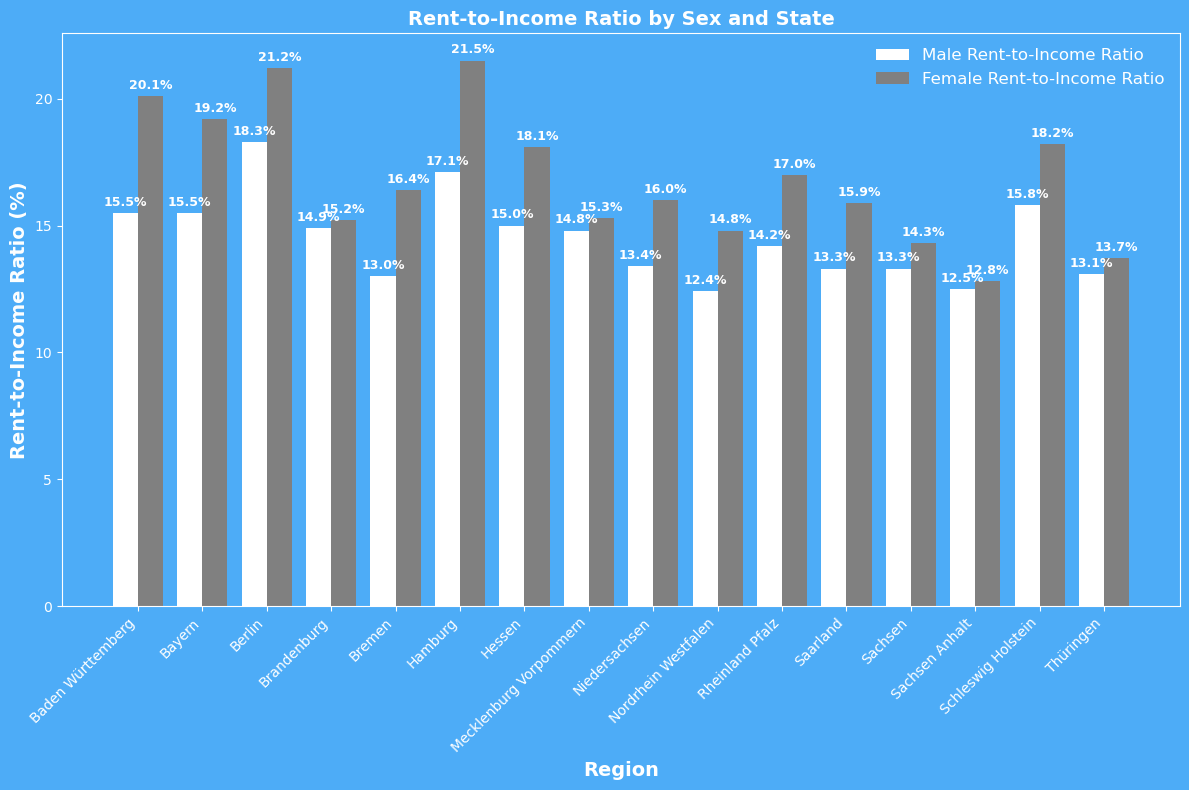

In [226]:
# Calculate the rent-to-salary ratios
sex_average_df['Male_Rent_to_Salary_Ratio'] = (sex_average_df['Average_Apartment_Price'] / sex_average_df['BS_Männer']) * 100
sex_average_df['Female_Rent_to_Salary_Ratio'] = (sex_average_df['Average_Apartment_Price'] / sex_average_df['BS_Frauen']) * 100

# Round values to two decimal places
sex_average_df[['Male_Rent_to_Salary_Ratio', 'Female_Rent_to_Salary_Ratio']] = sex_average_df[
    ['Male_Rent_to_Salary_Ratio', 'Female_Rent_to_Salary_Ratio']
].round(1)

# Prepare data for plotting
states = sex_average_df['regio1']
male_ratios = sex_average_df['Male_Rent_to_Salary_Ratio']
female_ratios = sex_average_df['Female_Rent_to_Salary_Ratio']

x = np.arange(len(states))  # Position for states
width = 0.39  # Width of the bars

# Create the grouped stacked bar chart
fig, ax = plt.subplots(figsize=(12, 8))

fig.patch.set_facecolor('#4dacf7')  # Background color outside plot area
ax.set_facecolor('#4dacf7')  # Background color inside plot area

bars1 = ax.bar(x - width/2, male_ratios, width, label='Male Rent-to-Income Ratio', color='white')
bars2 = ax.bar(x + width/2, female_ratios, width, label='Female Rent-to-Income Ratio', color='grey')

# Add value labels on top of each bar
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.1f}%',  # Formatting to 1 decimal place
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # Offset slightly above the bar
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9, color='white', fontweight='bold')

# Customize the plot
ax.set_xlabel('Region', color='white', fontsize=14, fontweight='bold')
ax.set_ylabel('Rent-to-Income Ratio (%)',color='white', fontsize=14, fontweight='bold')
ax.set_title('Rent-to-Income Ratio by Sex and State', color='white', fontsize=14, fontweight='bold')


# Set the border color to white
fig.patch.set_edgecolor('white')  # White border around the figure
ax.spines['top'].set_color('white')  # White border on the top
ax.spines['right'].set_color('white')  # White border on the right
ax.spines['left'].set_color('white')  # White border on the left
ax.spines['bottom'].set_color('white')  # White border on the bottom


# Set the x-ticks and x-tick labels
ax.set_xticks(x)
ax.set_xticklabels(states, rotation=45, ha="right", color='white')

# Set the legend
ax.legend(frameon=False, fontsize=12, loc='upper right', labelcolor='white')

# Set tick labels color
ax.tick_params(axis='both', colors='white')

plt.tight_layout()
plt.show()

In [227]:
mean_by_region = df.groupby('regio1')['price_m2'].mean().reset_index()
mean_by_region

# Export the resulting DataFrame to an Excel file
mean_by_region.to_excel('mean_price_m2_by_region.xlsx', index=False)

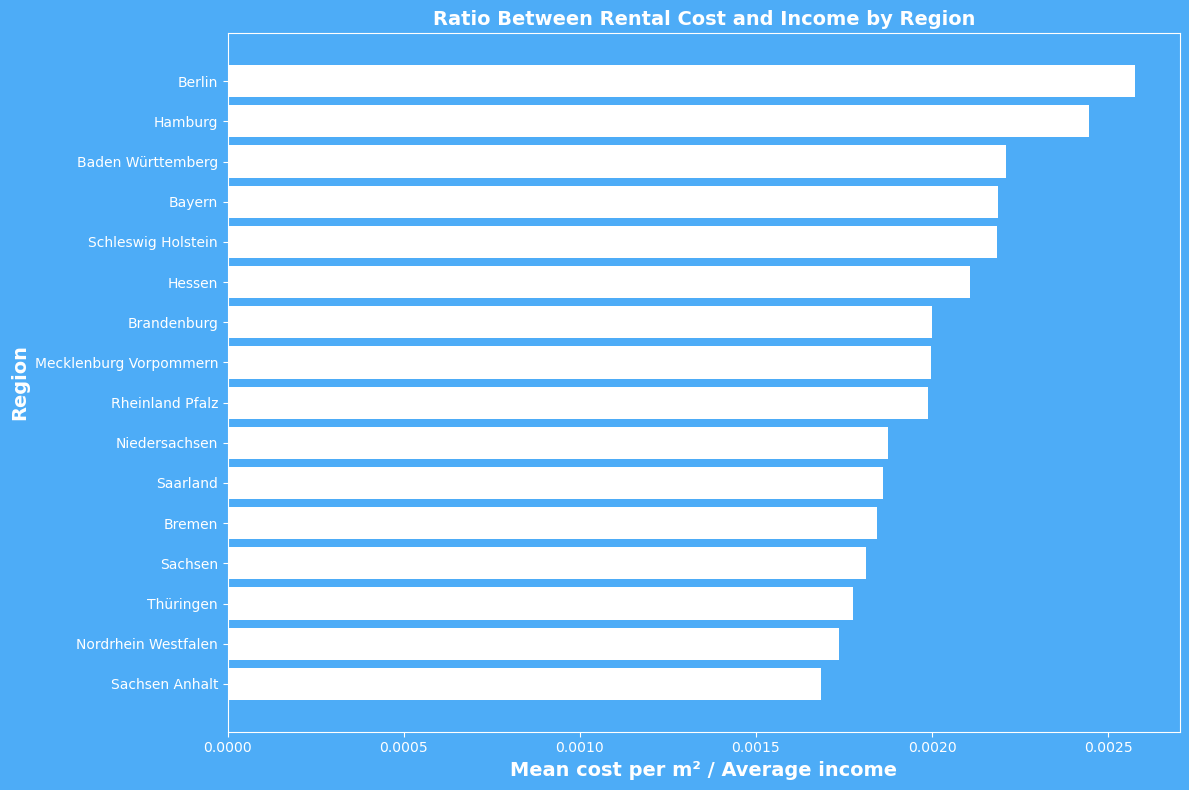

In [228]:
# Calculate the mean by region
mean_by_region_m2 = df.groupby('regio1')['price_m2_BS_Insgesamt'].mean().reset_index()

# Sort the DataFrame by mean values in descending order
mean_by_region_m2 = mean_by_region_m2.sort_values(by='price_m2_BS_Insgesamt', ascending=False)

# Create a horizontal bar plot
fig, ax = plt.subplots(figsize=(12, 8))  # Increase the figure dimensions

# Background color settings
fig.patch.set_facecolor('#4dacf7')  # Background color outside plot area
ax.set_facecolor('#4dacf7')  # Background color inside plot area

# Bar settings
ax.barh(mean_by_region_m2['regio1'], mean_by_region_m2['price_m2_BS_Insgesamt'], color='white')

# Invert the y-axis so the largest bar is on top
plt.gca().invert_yaxis()

# Label settings
ax.set_ylabel('Region', color='white', fontsize=14, fontweight='bold')  # Label for the y-axis
ax.set_xlabel('Mean cost per m² / Average income', color='white', fontsize=14, fontweight='bold')  # Label for the x-axis
ax.set_title('Ratio Between Rental Cost and Income by Region', color='white', fontsize=14, fontweight='bold')  # Title of the plot

# Border colors
ax.spines['top'].set_color('white')  # White border on the top
ax.spines['right'].set_color('white')  # White border on the right
ax.spines['left'].set_color('white')  # White border on the left
ax.spines['bottom'].set_color('white')  # White border on the bottom

# Tick labels
ax.tick_params(axis='both', colors='white')  # Set tick labels color

# Set the x-ticks and x-tick labels rotation and color
ax.set_yticks(mean_by_region_m2['regio1'])
ax.set_yticklabels(mean_by_region_m2['regio1'], rotation=0, ha="right", color='white')

plt.tight_layout()
plt.show()

regio1
Nordrhein Westfalen       32149
Sachsen                   28066
Sachsen Anhalt             9953
Bayern                     8305
Niedersachsen              8304
Hessen                     7294
Baden Württemberg          6724
Thüringen                  4271
Rheinland Pfalz            3968
Berlin                     3844
Brandenburg                3513
Schleswig Holstein         3465
Mecklenburg Vorpommern     3249
Bremen                     1478
Hamburg                    1423
Saarland                    718
Name: count, dtype: int64


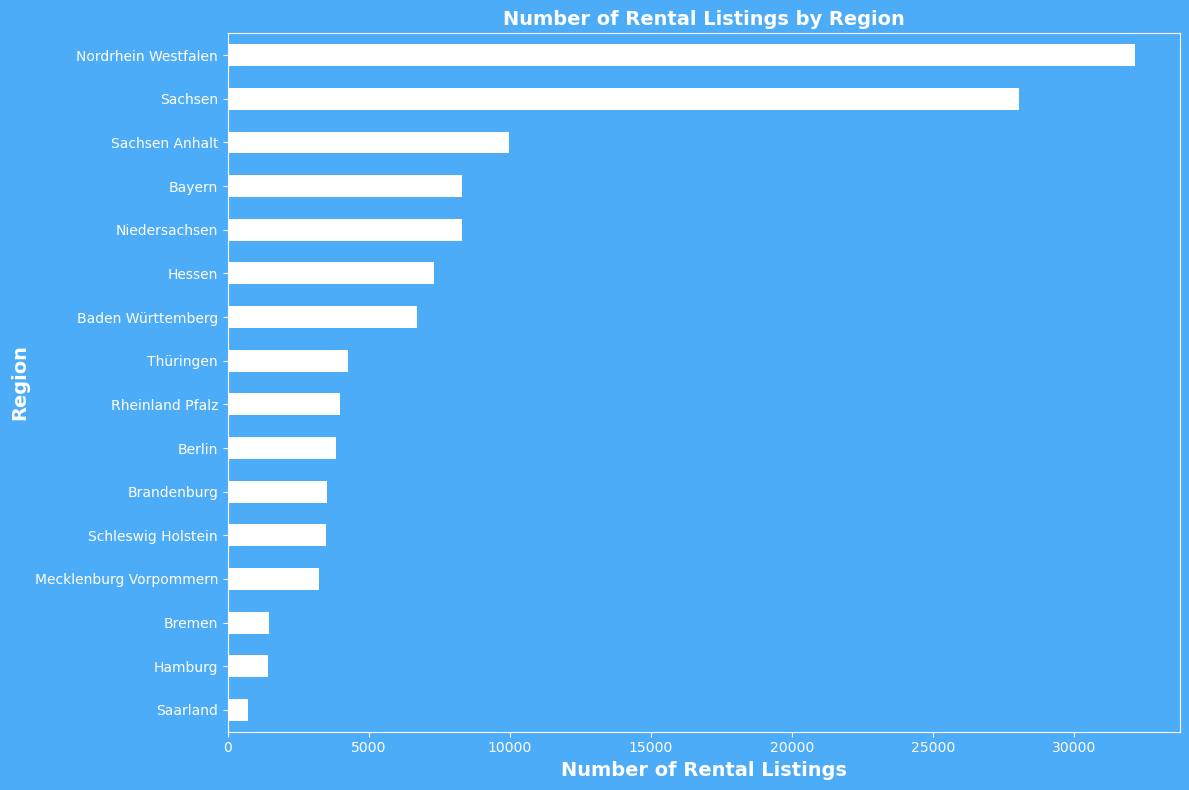

In [229]:
# Count the number of cases for each region, automatically sorted in descending order
region_count = df['regio1'].value_counts()

# Print the result
print(region_count)

# Create a horizontal bar plot of the counts
fig, ax = plt.subplots(figsize=(12, 8))  # Set the size of the plot

# Background color settings
fig.patch.set_facecolor('#4dacf7')  # Background color outside plot area
ax.set_facecolor('#4dacf7')  # Background color inside plot area

# Bar settings
region_count.plot(kind='barh', color='white', ax=ax)

# Invert the y-axis to display the largest count at the top
plt.gca().invert_yaxis()

# Label settings
ax.set_ylabel('Region', color='white', fontsize=14, fontweight='bold')  # Label for the y-axis
ax.set_xlabel('Number of Rental Listings', color='white', fontsize=14, fontweight='bold')  # Label for the x-axis
ax.set_title('Number of Rental Listings by Region', color='white', fontsize=14, fontweight='bold')  # Title of the plot

# Border colors
ax.spines['top'].set_color('white')  # White border on the top
ax.spines['right'].set_color('white')  # White border on the right
ax.spines['left'].set_color('white')  # White border on the left
ax.spines['bottom'].set_color('white')  # White border on the bottom

# Tick labels
ax.tick_params(axis='both', colors='white')  # Set tick labels color

# Set the y-ticks and y-tick labels rotation and color
ax.set_yticks(range(len(region_count)))
ax.set_yticklabels(region_count.index, rotation=0, ha="right", color='white')

plt.tight_layout()
plt.show()

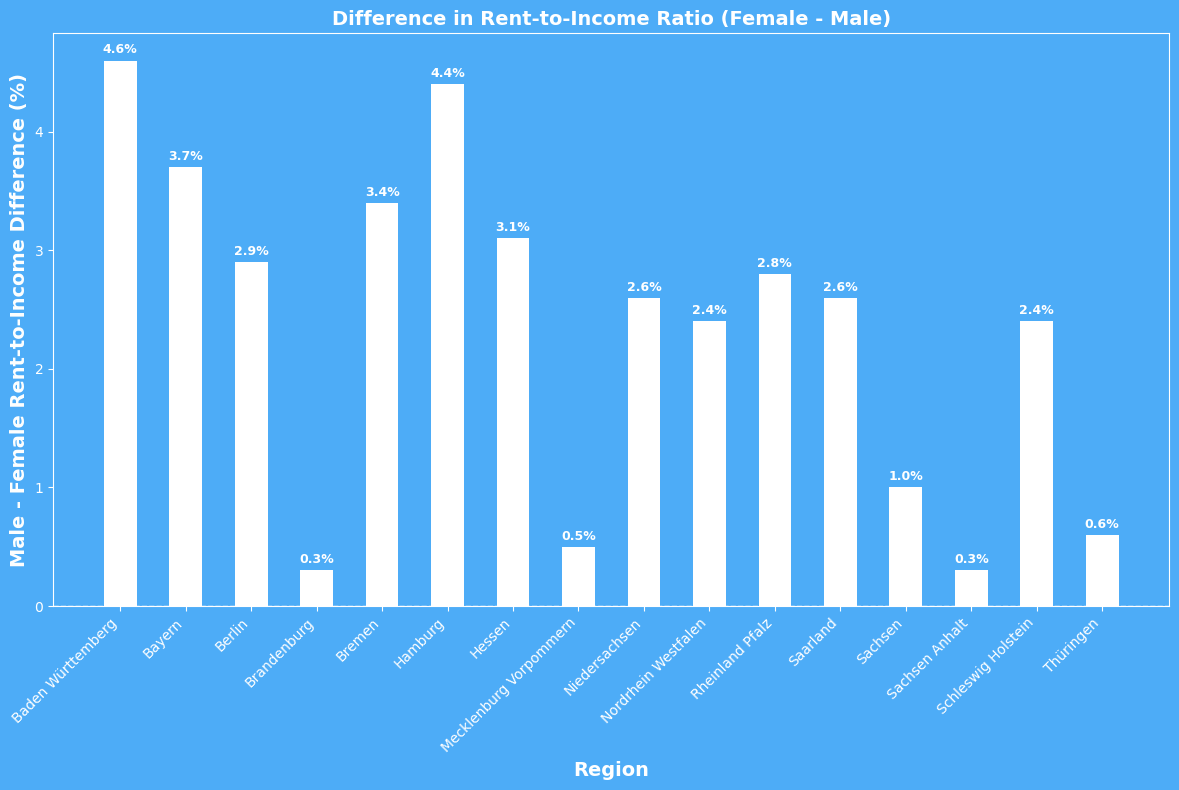

In [230]:
# Calculate the rent-to-salary ratio differences
sex_average_df['Rent_to_Salary_Difference'] = (sex_average_df['Female_Rent_to_Salary_Ratio']- sex_average_df['Male_Rent_to_Salary_Ratio']
).round(1)

# Prepare data for plotting
states = sex_average_df['regio1']
differences = sex_average_df['Rent_to_Salary_Difference']

x = np.arange(len(states))  # Position for states
width = 0.5  # Width of the bars

# Create the bar chart
fig, ax = plt.subplots(figsize=(12, 8))

fig.patch.set_facecolor('#4dacf7')  # Background color outside plot area
ax.set_facecolor('#4dacf7')  # Background color inside plot area

bars = ax.bar(x, differences, width, color=['white' if diff >= 0 else 'red' for diff in differences])

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height:.1f}%',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # Offset slightly above the bar
                textcoords="offset points",
                ha='center', va='bottom', fontsize=9, color='white', fontweight='bold')

# Customize the plot
ax.set_xlabel('Region', color='white', fontsize=14, fontweight='bold')
ax.set_ylabel('Male - Female Rent-to-Income Difference (%)', color='white', fontsize=14, fontweight='bold')
ax.set_title('Difference in Rent-to-Income Ratio (Female - Male)', color='white', fontsize=14, fontweight='bold')

# Set the border color to white
fig.patch.set_edgecolor('white')  
ax.spines['top'].set_color('white')  
ax.spines['right'].set_color('white')  
ax.spines['left'].set_color('white')  
ax.spines['bottom'].set_color('white')  

# Set the x-ticks and x-tick labels
ax.set_xticks(x)
ax.set_xticklabels(states, rotation=45, ha="right", color='white')

# Set tick labels color
ax.tick_params(axis='both', colors='white')

# Add horizontal line at zero for reference
ax.axhline(0, color='white', linewidth=1, linestyle='--')

plt.tight_layout()
plt.show()

C:\Users\barba\AppData\Local\Temp\ipykernel_10972\849603778.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=df['livingSpace_bins'], y=df['price_m2'], estimator=np.mean, palette=bar_colors, errorbar=None)


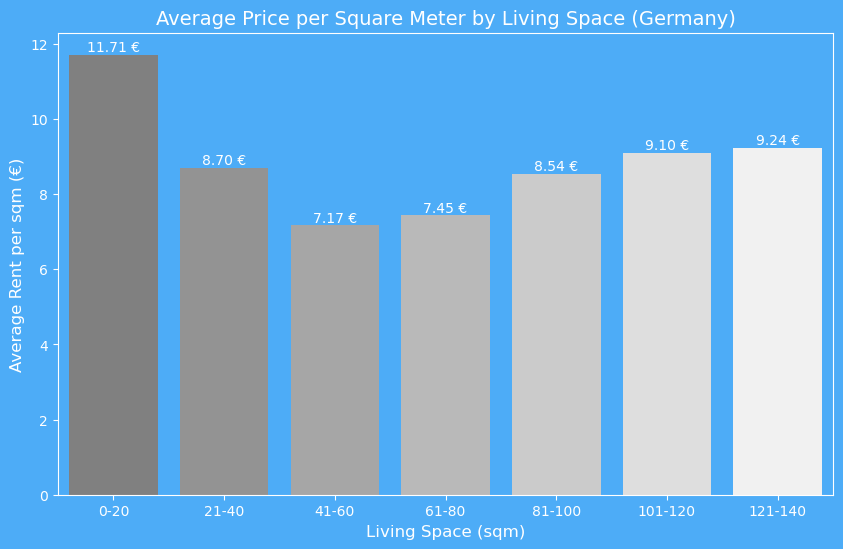

In [231]:
# Create square meter buckets
df['livingSpace_bins'] = pd.cut(df['livingSpace'], bins=[0, 20, 40, 60, 80, 100, 120, 140], 
                               labels=['0-20', '21-40', '41-60', '61-80', '81-100', '101-120', '121-140'])

# Create the figure with the background color set to '#4dacf7'
plt.figure(figsize=(10, 6), facecolor='#4dacf7')

# Create bar plot with 'Blues' palette but modify the bars to shades of white and gray
bar_colors = sns.light_palette("gray", n_colors=len(df['livingSpace_bins'].unique()), reverse=True)

# Create the plot using the custom color palette
ax = sns.barplot(x=df['livingSpace_bins'], y=df['price_m2'], estimator=np.mean, palette=bar_colors, errorbar=None)

# Set background color for the plot area (axes) to '#4dacf7'
ax.set_facecolor('#4dacf7')

# Adding labels on top of bars by using ax.patches to get the bar heights
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f} €', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                color='white', fontsize=10, 
                xytext=(0, 5), textcoords='offset points')

# Set plot title and labels with white text
plt.title("Average Price per Square Meter by Living Space (Germany)", fontsize=14, color='white')
plt.xlabel("Living Space (sqm)", fontsize=12, color='white')
plt.ylabel("Average Rent per sqm (€)", fontsize=12, color='white')

# Remove grid lines inside the plot
plt.grid(False)

# Change tick label colors to white
plt.tick_params(axis='x', colors='white')
plt.tick_params(axis='y', colors='white')

# Remove the spines (borders) of the plot area to make it clean
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_color('white')

# Show the plot
plt.show()

In [ ]:
# Filter the data to include only entries for Berlin and calculate the average price per square meter by date
berlin_data = df[df['regio1'] == 'Berlin']  # Filter the DataFrame to include only rows where 'regio1' is 'Berlin'

average_price_m2_by_date = berlin_data.groupby('date')['price_m2'].mean().reset_index()
# Group the Berlin data by 'date' and calculate the mean of 'price_m2' for each date, resetting the index for clarity

print(average_price_m2_by_date)

In [ ]:
#This code creates an Excel file with the average rental price per square meter in Berlin
average_price_m2_by_date.to_excel('average_price_m2_berlin.xlsx', index=False)

In [ ]:
#Calculate the average rental price per square meter throughout Germany
average_price_m2_by_date = df.groupby('date')['price_m2'].mean().reset_index()

print(average_price_m2_by_date)

In [ ]:
#This code creates an Excel file with the average rental price per square meter throughout Germany
average_price_m2_by_date.to_excel('average_price_m2_all_regions.xlsx', index=False)

In [ ]:
#Import inflation data from an Excel file created in another Notebook from information taken from a web page
file_path = 'inflation_data.xlsx'  
df_inflation = pd.read_excel(file_path)
df_inflation

In [ ]:
# Ensure the 'month' column is converted to datetime type if it isn't already
df_inflation['month'] = pd.to_datetime(df_inflation['month'])

# Create the line plot
fig, ax = plt.subplots(figsize=(12, 8))

# Set background colors
fig.patch.set_facecolor('#4dacf7')  # Background color outside the plot area
ax.set_facecolor('#4dacf7')  # Background color inside the plot area

# Plot inflation data
ax.plot(df_inflation['month'], df_inflation['inflation'], label='Inflation', marker='o', color='white')

# Plot price_m2_all data
ax.plot(df_inflation['month'], df_inflation['price_m2_all'], label='Price per m2 (All)', marker='x', color='yellow')

# Set labels and title
ax.set_title('Inflation and Price per m2 Comparison Over Time', color='white', fontsize=14, fontweight='bold')
ax.set_xlabel('Month', color='white', fontsize=14, fontweight='bold')
ax.set_ylabel('Values', color='white', fontsize=14, fontweight='bold')

# Display the legend
ax.legend()

# Set border colors
ax.spines['top'].set_color('white')
ax.spines['right'].set_color('white')
ax.spines['left'].set_color('white')
ax.spines['bottom'].set_color('white')

# Set tick labels color
ax.tick_params(axis='both', colors='white')

# Improve date visualization on the x-axis
plt.xticks(rotation=45, color='white')

# Adjust the layout to prevent text from being cut off
plt.tight_layout()

# Show the plot
plt.show()